In [2]:
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard#
Stacked Regressions to predict House Prices
Serigne 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [4]:
dataset = pd.read_csv('./data/filled_dataset.csv')
#dataset = dataset.drop(['Id'], axis=1) # Do Not drop ID
train = dataset[dataset['SalePrice'] > 100]
test = dataset[dataset['SalePrice'] == 99] # this was set to 99 during data compilation
#print (train.shape)
#print (test.shape)
train = train[train.GrLivArea < 4000]
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate
0,1461,20,RH,80.000,11622,Pave,None,Reg,Lvl,AllPub,...,6,2010,WD,Normal,99,201006,183.000,4.561,51950.000,4.700
1,1462,20,RL,81.000,14267,Pave,None,IR1,Lvl,AllPub,...,6,2010,WD,Normal,99,201006,183.000,4.561,51950.000,4.700
2,1463,60,RL,74.000,13830,Pave,None,IR1,Lvl,AllPub,...,3,2010,WD,Normal,99,201003,193.370,4.762,53639.000,4.600
3,1464,60,RL,78.000,9978,Pave,None,IR1,Lvl,AllPub,...,6,2010,WD,Normal,99,201006,183.000,4.561,51950.000,4.700
4,1465,120,RL,43.000,5005,Pave,None,IR1,HLS,AllPub,...,1,2010,WD,Normal,99,201001,168.830,4.993,52631.000,4.800


In [5]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1456, 86) 
The test data size before dropping Id feature is : (1459, 86) 

The train data size after dropping Id feature is : (1456, 85) 
The test data size after dropping Id feature is : (1459, 85) 


#### taking a look at the target variable

C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180151.23 and sigma = 76670.25



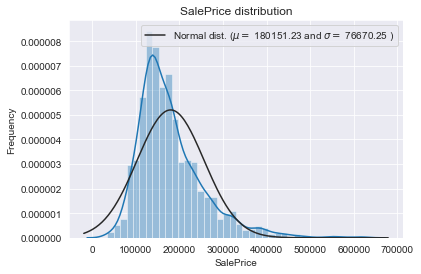

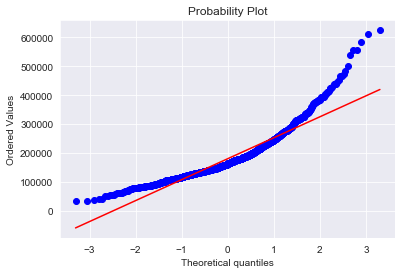

In [6]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



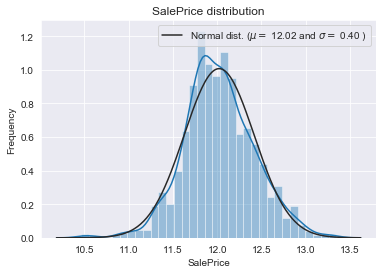

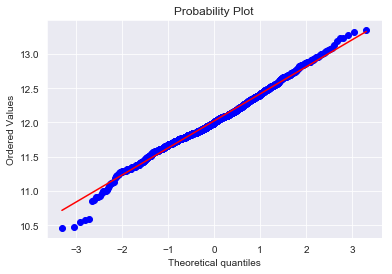

In [7]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### Features Engineering

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 84)


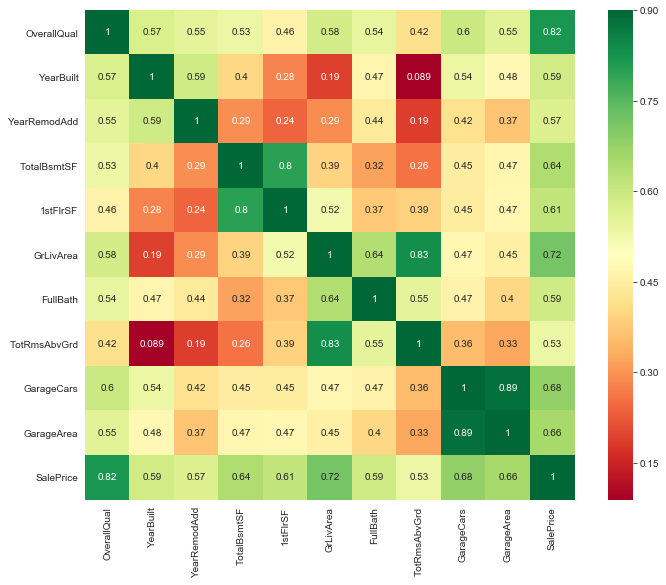

In [9]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(12,9))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn", vmax=0.9, square=True)

In [10]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [11]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2915, 84)


In [12]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [13]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.932
PoolArea,18.702
LotArea,13.124
LowQualFinSF,12.080
3SsnPorch,11.368
LandSlope,4.971
KitchenAbvGr,4.299
BsmtFinSF2,4.143
EnclosedPorch,4.001
ScreenPorch,3.944


In [14]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 64 skewed numerical features to Box Cox transform


In [15]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [16]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,Month,DJREI,Fannie,LaborForce,UnemplRate,TotalSF
0,2.886,RL,5.831,19.212,0.730,0.730,1.541,Lvl,AllPub,Inside,...,1.820,1.194,WD,Normal,34.955,8.554,2.168,27.062,1.541,14.977
1,2.056,RL,6.221,19.712,0.730,0.730,1.541,Lvl,AllPub,FR2,...,2.440,0.730,WD,Normal,34.952,9.280,2.285,26.864,1.412,14.923
2,2.886,RL,5.915,20.347,0.730,0.730,0.000,Lvl,AllPub,Inside,...,3.011,1.194,WD,Normal,34.956,8.529,2.299,27.072,1.541,15.150
3,3.011,RL,5.685,19.692,0.730,0.730,0.000,Lvl,AllPub,Corner,...,1.820,0.000,WD,Abnorml,34.949,8.824,2.283,26.910,1.510,14.857
4,2.886,RL,6.315,21.325,0.730,0.730,0.000,Lvl,AllPub,FR2,...,1.541,1.194,WD,Normal,34.956,7.421,2.086,27.086,1.742,15.852


In [11]:
#all_data[skewed_feats].head() #this is the log transformation variables

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LaborForce
0,4.111,4.190,9.042,5.283,0.000,5.017,6.753,6.751,0.000,7.445,0.000,0.693,0.000,4.127,0.000,0.000,0.000,0.000,0.000,10.808
1,3.045,4.394,9.170,0.000,0.000,5.652,7.141,0.000,0.000,7.141,0.693,0.693,5.700,0.000,0.000,0.000,0.000,0.000,0.000,10.769
2,4.111,4.234,9.328,5.094,0.000,6.075,6.825,6.765,0.000,7.488,0.000,0.693,0.000,3.761,0.000,0.000,0.000,0.000,0.000,10.810
3,4.263,4.111,9.164,0.000,0.000,6.293,6.869,6.629,0.000,7.449,0.000,0.693,0.000,3.584,5.609,0.000,0.000,0.000,0.000,10.778
4,4.111,4.443,9.565,5.861,0.000,6.196,7.044,6.960,0.000,7.696,0.000,0.693,5.263,4.443,0.000,0.000,0.000,0.000,0.000,10.813


In [17]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2915, 227)


In [18]:
train = all_data[:ntrain]
test = all_data[ntest:]

### Modelling

In [19]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
#conda install -c conda-forge lightgbm 
import lightgbm as lgb

In [20]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Base Models

In [21]:
#Lasso Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [23]:
#Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [22]:
#Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [24]:
#Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [25]:
#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [26]:
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Base models scores

In [27]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1111 (0.0073)



In [28]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1111 (0.0073)



In [29]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1155 (0.0087)



In [30]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1174 (0.0062)



In [31]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1159 (0.0040)



### Simplest Stacking approach : Averaging base models
- We begin with this simple approach of averaging base models.
- We build a new class to extend scikit-learn with our model and also to leverage encapsulation and code reuse (inheritance)

In [32]:
#Averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [33]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1086 (0.0072)



In [34]:
#averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [35]:
#averaged base models score
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1086 (0.0072)



## Less simple Stacking : Adding a Meta-model

In [36]:
#stacking averaged models class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [37]:
#Stacking Averaged models Score
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Stacking Averaged models score: 0.1079 (0.0067)


#### Ensembling StackedRegressor, XGBoost and LightGBM

In [38]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### Final Training and Prediction

In [39]:
#stacked regressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07715073188472568


In [40]:
#XGBoost:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08016158666490966


In [41]:
#LightGBM:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07038021855679252


In [42]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07451760647229752


In [43]:
#Ensemble prediction:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [61]:
#len(ensemble)
#Submission
sub = pd.DataFrame()
sub['Id'] = train_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission2.csv',index=False)

In [63]:
sub.head()

,Id,SalePrice
1459,1,194958.120
1460,2,192212.364
1461,3,172671.746
1462,4,176462.966
1463,5,164444.377
